### 03 앙상블 학습

- 앙상블 학습: 여러개의 분류기를 생성하고 그 예측을 결합함으로써 보다 정확한 최종 에측을 도출하는 기법
- 앙상블 - 배깅(랜덤포레스트), 부스팅(그래디언트 부스팅, XGBoost, LightGBM): 가중치 부여
- 보팅과 배깅: 여러개의 분류기가 투표를 통해 최종 에측 결과를 결정하는 방식
- 보팅은 서로 다른 알고리즘을 가진 분류기를 결합

In [1]:
# 보팅 -하드보팅과 소프트 보팅 

# 보팅 방식의 앙상블을 이용해
# 위스콘신 유방암 데이터 세트 예측 분석

import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


로지스틱 회귀와 KNN을 기반으로 하여 소프트 보팅 방식으로 
새로운 보팅 분류기 생성

In [3]:
# 개별 모델은 로지스틱 회귀와 KNN임
lr_clf = LogisticRegression()
knn_clf=KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)],voting='soft')

X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,test_size =0.2,random_state=156)

#VotingClassifier 학습/예측/평가
vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도:{0:.4f}'.format(accuracy_score(y_test,pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf,knn_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred=classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도:{1:.4f}'.format(class_name,accuracy_score(y_test,pred)))

Voting 분류기 정확도:0.9561
LogisticRegression 정확도:0.9474
KNeighborsClassifier 정확도:0.9386


C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


배깅과 부스팅은 대부분 결정 트리 알고리즘을 기반으로 하지만 결정 트리에서 대두됬던 과적합 문제를 많은 분류기를
결합해 보완하면서 편향-분산 트레이드오프의 효과를 극대화 시킴

### 파이썬 래퍼 XGBoost

- 초기모듈 파이썬 래퍼 XGBoost 를 사용
- xgboost 는 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화 기능이 있다.
- 또한, 조기 중단 기능이 있어 num_rounds 로 지정한 부스팅 반복 횟수에 도달하지 않더라도 예측 오류가 개선되지 않으면 중간 중단


In [1]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())
# m: 악성

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [4]:
# 전체 데이터 중 80% 는 학습용 데이터, 20% 는 테스트용 데이터 추출
X_train,X_test,y_train,y_test = train_test_split(X_features,y_label, test_size=0.2,random_state=156)
print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


In [5]:
# 파이썬 래퍼 XGBoost 만의 특징: 학습용과 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix 생성
# 넘파이 형태의 학습,테스트 데이터 세트를 DMatrix로 변환
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

In [7]:
# 하이퍼 파라미터 설정
params = {'max_depth':3,
         'eta':0.1,
         'objective':'binary:logistic',
         'early_stoppings':100
         }
num_rounds = 400

- early_stopping_rounds 파라미터를 설정해 조기 중단을 수행하기 위해서는 eval_set과 eval_metric 이 설정되어야함
- eval_set: 성능 평가를 수행할 평가용 데이터 세트를 설정
- eval_metric :평가 세트에 적용할 성능 평가 방법, 분류일 경우 'error'(분류오류), 'logloss'를 주로 사용

In [9]:
# train 데이터 세트는 'train', evaluation(test)데이터 세트는 'eval'로 명기
wlist=[(dtrain,'train'),(dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round = num_rounds,evals=wlist)

[0]	train-error:0.030769	eval-error:0.052632
[1]	train-error:0.026374	eval-error:0.061404
[2]	train-error:0.017582	eval-error:0.052632
[3]	train-error:0.021978	eval-error:0.061404
[4]	train-error:0.013187	eval-error:0.052632
[5]	train-error:0.013187	eval-error:0.052632
[6]	train-error:0.013187	eval-error:0.052632
[7]	train-error:0.013187	eval-error:0.052632
[8]	train-error:0.013187	eval-error:0.052632
[9]	train-error:0.013187	eval-error:0.052632
[10]	train-error:0.015385	eval-error:0.052632
[11]	train-error:0.013187	eval-error:0.052632
[12]	train-error:0.015385	eval-error:0.052632
[13]	train-error:0.013187	eval-error:0.052632
[14]	train-error:0.010989	eval-error:0.052632
[15]	train-error:0.010989	eval-error:0.052632
[16]	train-error:0.008791	eval-error:0.052632
[17]	train-error:0.008791	eval-error:0.052632
[18]	train-error:0.008791	eval-error:0.052632
[19]	train-error:0.008791	eval-error:0.04386
[20]	train-error:0.008791	eval-error:0.04386
[21]	train-error:0.008791	eval-error:0.04386
[

[199]	train-error:0	eval-error:0.035088
[200]	train-error:0	eval-error:0.035088
[201]	train-error:0	eval-error:0.035088
[202]	train-error:0	eval-error:0.035088
[203]	train-error:0	eval-error:0.035088
[204]	train-error:0	eval-error:0.035088
[205]	train-error:0	eval-error:0.035088
[206]	train-error:0	eval-error:0.035088
[207]	train-error:0	eval-error:0.035088
[208]	train-error:0	eval-error:0.035088
[209]	train-error:0	eval-error:0.035088
[210]	train-error:0	eval-error:0.035088
[211]	train-error:0	eval-error:0.035088
[212]	train-error:0	eval-error:0.035088
[213]	train-error:0	eval-error:0.035088
[214]	train-error:0	eval-error:0.035088
[215]	train-error:0	eval-error:0.035088
[216]	train-error:0	eval-error:0.035088
[217]	train-error:0	eval-error:0.035088
[218]	train-error:0	eval-error:0.035088
[219]	train-error:0	eval-error:0.035088
[220]	train-error:0	eval-error:0.035088
[221]	train-error:0	eval-error:0.035088
[222]	train-error:0	eval-error:0.035088
[223]	train-error:0	eval-error:0.035088


In [12]:
# xgboost 의 predict()는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환
pred_probs = xgb_model.predict(dtest)
print('predict()수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict()수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [14]:
# xgboost 예측 성능 평가- get_clf_eval()


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [16]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [ ]:
# 시각화 - plot_importance() : 바로 피처의 중요도 시각화
# xgboost 넘파이 기반의 피처 데이터로 학습시에 피처명을 알 수 없으므로 피처 순서별로 f자 뒤에 순서를 붙이기 

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

to_graphviz() 로 결정 트리에서의 규칙 트리 구조를 그릴 수 있다. 

### 사이킷런 래퍼 XGBoost 

사이킷런의 프레임워크와 연동하기 위해 개발

In [22]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
xgb_wrapper.fit(X_train,y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [23]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [34]:
# 여기서는 테스트 데이터 세트로 평가를 하였지만 미리 참고가 되어 과적합할 수 있기 때문에 바람직한 방법은 아님
from xgboost import XGBClassifier 

xgb_wrapper = XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric="logloss",
               eval_set = evals, verbose =True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

In [35]:
get_clf_eval(y_test,ws100_preds,ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [37]:
# early_stopping_rounds 를 10으로 설정하고 재 학습...조기 중단값을 급격하게 줄이면 오히려 정확도가 낮아짐 
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=10,eval_metric='logloss',eval_set = evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test,ws100_preds,ws100_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


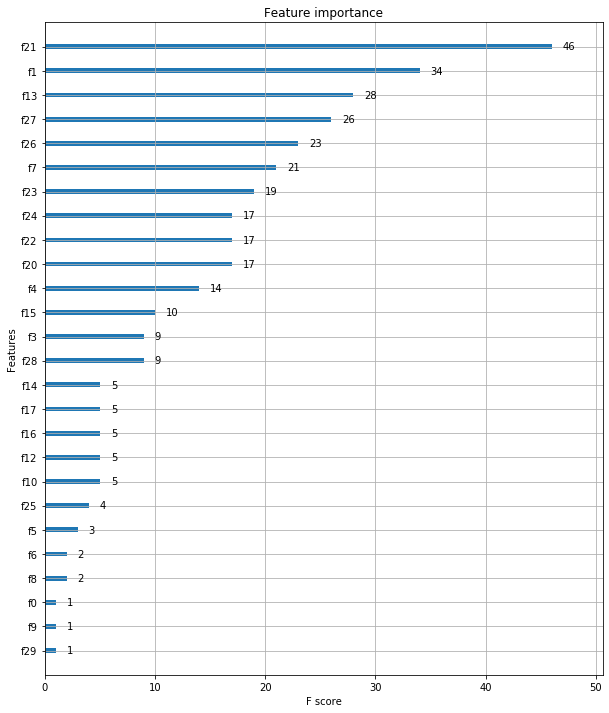

In [39]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper,ax=ax)                    

### 07 LightGBM

- XGBoost 보다 학습에 걸리는 시간이 훨씬 적고 에측 성능도 차이 없다.
- 하지만, 적은 데이터 세트에 적용할 경우 과적합 발생 가능
- 리프 중심 트리 분할 사용 (leaf wise)   (대부분, 균형트리분할(level wise) 사용 )- 비대칭적으로 트리의 깊이가 깊어지는 방식

사이킷런 래퍼 LightGBM 과 사이킷런 래퍼 XGBoost의 하이퍼파라미터는 매우 유사

In [43]:
# LightGBM 적용

# LightGBM의 파이썬 패키진인 lightgbm 에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

X_train, X_test, y_train, y_test = train_test_split(ftr,target,test_size=0.2, random_state=156)

# 앞서 XGBoost 와 동일하게 n_estimator는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM 도 XGBoost 와 동일하게 조기 중단 수행 가능
evals = [(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]   # 더 큰 확률 값을 빼기위함 

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865
[14]	valid_0's binary_logloss: 0.215076
[15]	valid_0's binary_logloss: 0.205996
[16]	valid_0's binary_logloss: 0.196091
[17]	valid_0's binary_logloss: 0.186395
[18]	valid_0's binary_logloss: 0.17942
[19]	valid_0's binary_logloss: 0.174727
[20]	valid_0's binary_logloss: 0.168563
[21]	valid_0's binary_logloss: 0.165432
[22]	valid_0's binary_logloss: 0.160356
[23]	valid_0's binary_logloss: 0.155508
[24]	valid_0's binary_logloss: 

In [44]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740,    F1: 0.9615, AUC:0.9926


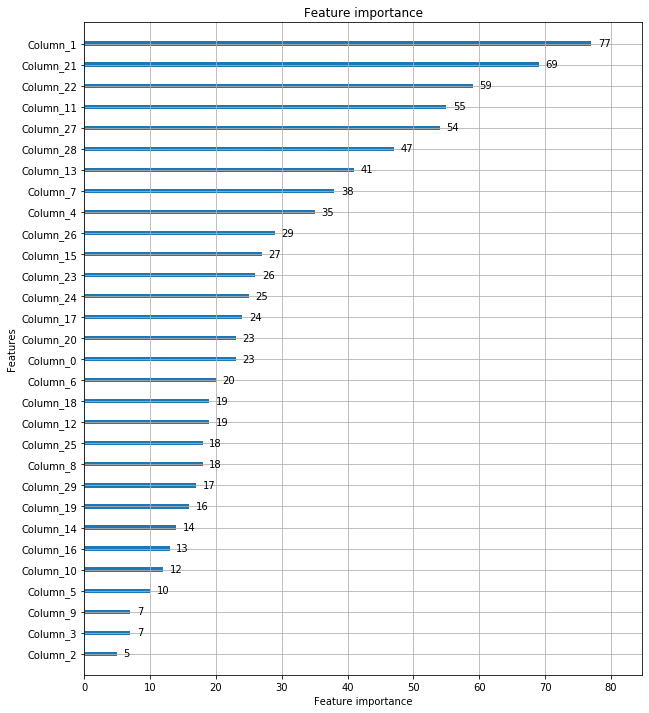

In [45]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax =plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)